In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
import torch
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import numpy as np
import pickle
import io

In [59]:
torch.manual_seed(256)
torch.cuda.manual_seed(256)
np.random.seed(256)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cpu device.


# 2. Object Localization

1. Load the 3 localization datasets `localization XXX.pt`. There is at most one digit per image. All digits are represented ($C$ = 10).

In [4]:
train_dataset = torch.load('data/localization_train.pt')
val_dataset = torch.load('data/localization_val.pt')
test_dataset = torch.load('data/localization_test.pt')

In [5]:
print(f"Training Set: {len(train_dataset)} images")
print(f"Validation Set: {len(val_dataset)} images")
print(f"Test Set: {len(test_dataset)} images")

Training Set: 59400 images
Validation Set: 6600 images
Test Set: 11000 images


In [6]:
sample_image, sample_label = train_dataset[0]
print(f"Sample Image: {sample_image}")  # values suggest that the data is already normalized
print(f"Sample Image Shape: {sample_image.shape}")
print(f"Sample Label: {sample_label}")

Sample Image: tensor([[[0.3647, 0.2938, 0.2765,  ..., 0.3936, 0.3678, 0.5296],
         [0.2512, 0.2223, 0.3063,  ..., 0.4712, 0.3880, 0.3778],
         [0.2182, 0.1546, 0.3569,  ..., 0.6240, 0.3413, 0.4354],
         ...,
         [0.6697, 0.6960, 0.2436,  ..., 0.3731, 0.5221, 0.4018],
         [0.8009, 0.6783, 0.4918,  ..., 0.5213, 0.3627, 0.2501],
         [0.8217, 0.7294, 0.3937,  ..., 0.6089, 0.1960, 0.3527]]])
Sample Image Shape: torch.Size([1, 48, 60])
Sample Label: tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000])


In [7]:
def check_normalization(datasets):
    min_pixel_value = float('inf')
    max_pixel_value = -float('inf')

    for dataset in datasets:
        for image, _ in dataset:
            min_pixel_value = min(min_pixel_value, image.min().item())
            max_pixel_value = max(max_pixel_value, image.max().item())

    return min_pixel_value, max_pixel_value


min_pixel_value, max_pixel_value = check_normalization([train_dataset, val_dataset, test_dataset])
min_pixel_value, max_pixel_value

(0.0, 1.0)

In [8]:
cmap = sns.color_palette("cubehelix_r", n_colors=20)  # custom cmap

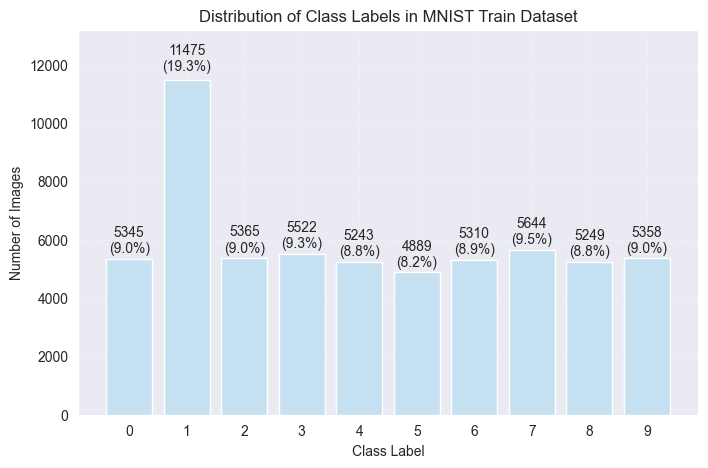

In [9]:
class_counter = Counter()

for _, label in train_dataset:
    class_label = int(label[-1].item())
    class_counter[class_label] += 1

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counter.keys(), class_counter.values(), color=cmap[2])

# text annotations above each bar
for bar, count in zip(bars, class_counter.values()):
    percentage = f"{count / sum(class_counter.values()) * 100:.1f}%"
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() / 0.98,
             f"{count}\n({percentage})",
             ha='center', va='bottom')

plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Class Labels in MNIST Train Dataset')
plt.xticks(range(0, 10))
plt.ylim(0, max(class_counter.values()) * 1.15)
plt.grid(linestyle='--', alpha=0.3)
plt.show()

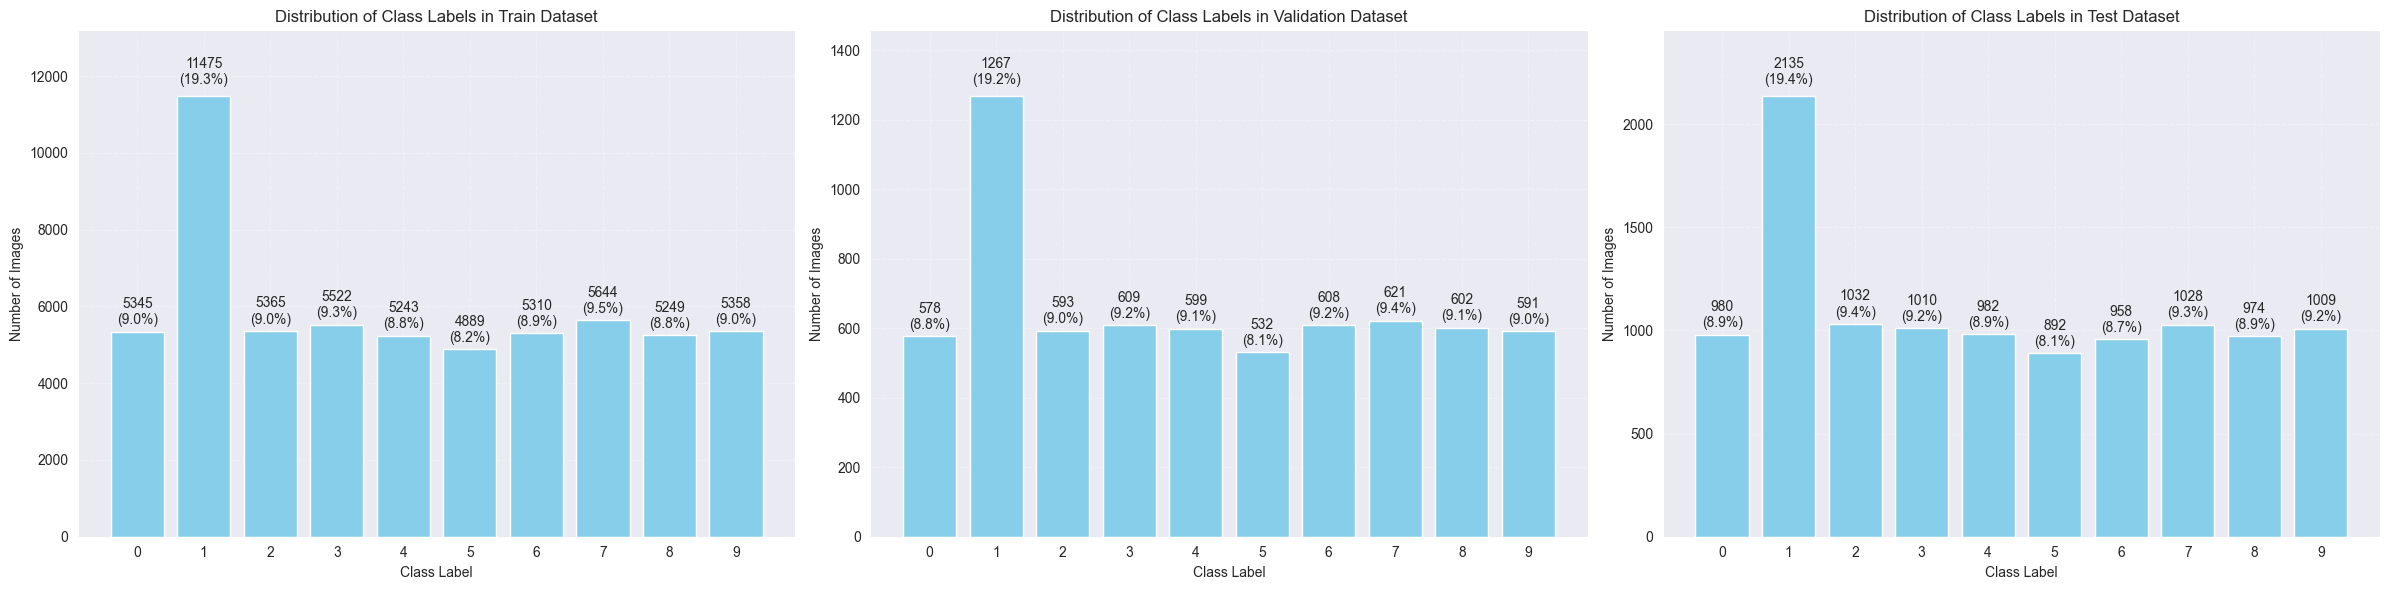

In [10]:
bar_color = 'skyblue'

datasets = {
    'Train Dataset': train_dataset,
    'Validation Dataset': val_dataset,
    'Test Dataset': test_dataset,
}

plt.figure(figsize=(24, 6))

for i, (dataset_name, dataset) in enumerate(datasets.items(), 1):
    class_counter = Counter()
    for _, label in dataset:
        class_label = int(label[-1].item())
        class_counter[class_label] += 1

    ax = plt.subplot(1, 3, i)
    bars = ax.bar(class_counter.keys(), class_counter.values(), color=bar_color)

    for bar, count in zip(bars, class_counter.values()):
        percentage = f"{count / sum(class_counter.values()) * 100:.1f}%"
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 0.98,
                f"{count}\n({percentage})",
                ha='center', va='bottom')

    ax.set_xlabel('Class Label')
    ax.set_ylabel('Number of Images')
    ax.set_title(f'Distribution of Class Labels in {dataset_name}')
    ax.set_xticks(range(0, 10))
    ax.set_ylim(0, max(class_counter.values()) * 1.15)
    ax.grid(linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
def get_bbox(x, y, w, h, img_height=48, img_width=60):
    # convert bounding box format from [center_x, center_y, width, height] to [x_min, y_min, x_max, y_max]
    x_min = (x - w / 2) * img_width
    y_min = (y - h / 2) * img_height
    x_max = (x + w / 2) * img_width
    y_max = (y + h / 2) * img_height
    return [x_min, y_min, x_max, y_max]

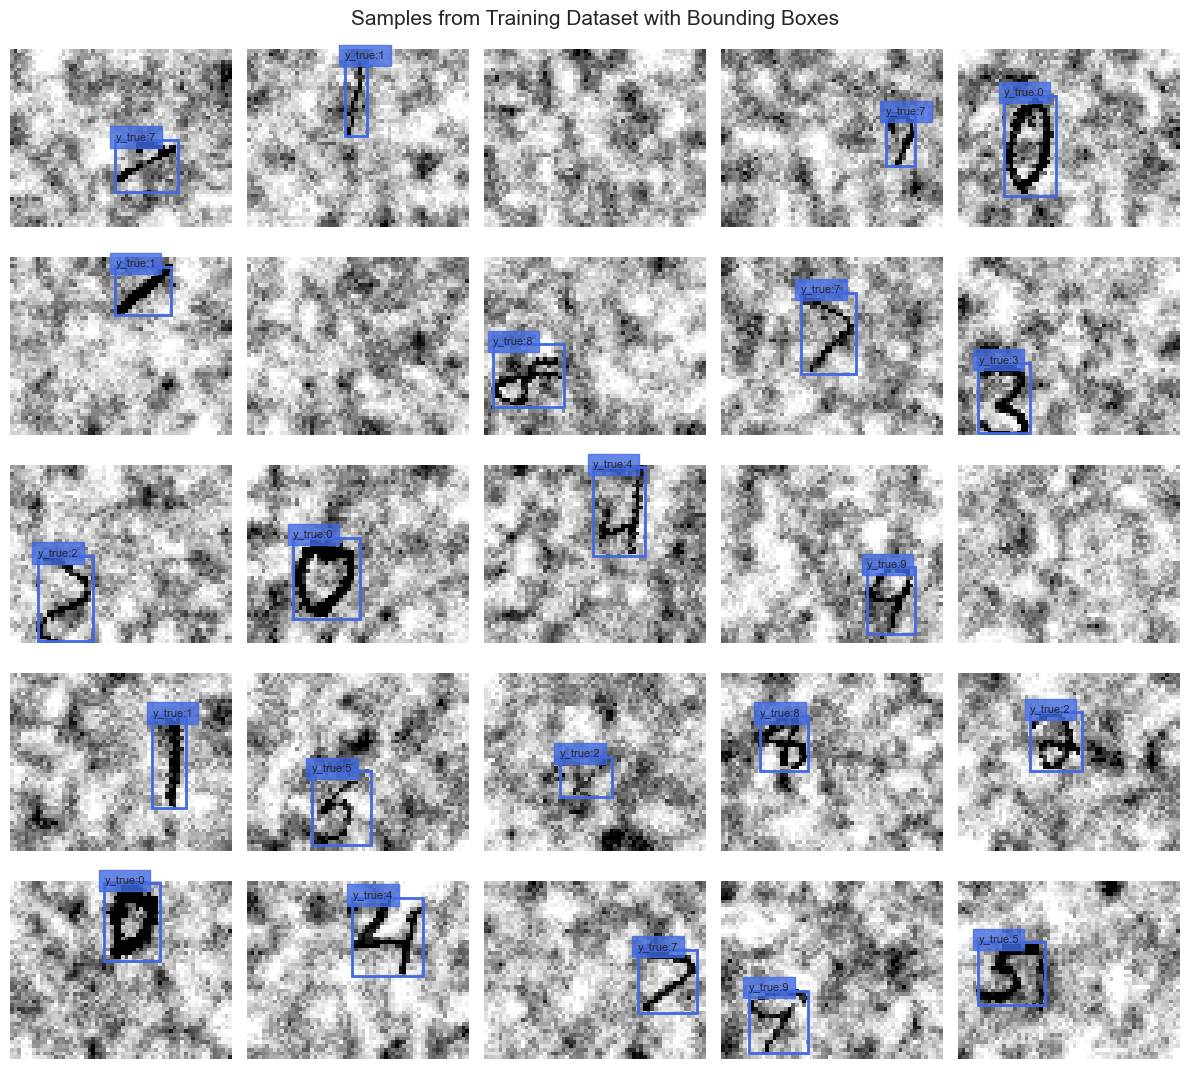

In [13]:
img_height, img_width = 48, 60
sample_indices = np.random.choice(len(train_dataset), 25, replace=False)

fig, axs = plt.subplots(5, 5, figsize=(12, 11))

for ax, idx in zip(axs.ravel(), sample_indices):
    img, (p_c, x, y, w, h, c) = train_dataset[idx]
    img = (img * 255).to(torch.uint8).numpy().squeeze()

    if p_c:
        x_min, y_min, x_max, y_max = get_bbox(x, y, w, h)

        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor="royalblue",
                         facecolor="none")
        ax.add_patch(rect)
        ax.text(x_min, y_min, f"y_true:{int(c)}", fontsize=8,
                bbox=dict(facecolor="royalblue", alpha=0.8, edgecolor="royalblue"))

    ax.imshow(img, cmap="Greys")
    ax.axis("off")

fig.suptitle("Samples from Training Dataset with Bounding Boxes", fontsize=15)
plt.tight_layout()
plt.show()

2. Implement and train several convolutional models suitable for an object localization task and the data provided.

In [14]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        # Conv1: Input 48x60x1 -> Output 44x56x6

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        # Conv2: Input 22x28x6 -> Output 18x24x16

        # Avg-pooling Layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # Pooling: Reduces the size by half

        self.fc1 = nn.Linear(9 * 12 * 16, 120)
        # FC1: Fully connected layer, the flattened input from Conv2 pooling output is 9*12*16

        self.fc2 = nn.Linear(120, 84)
        # FC2: Second fully connected layer from 120 to 84 neurons

        self.fc3 = nn.Linear(84, num_classes + 5)
        # FC3: Output layer for classification + localization, outputting num_classes + 5

    def forward(self, x):
        # Convolutional and pooling layers sequence
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flattening Conv2 pool output for the fully connected layers
        x = torch.flatten(x, 1)  # Flattening all dimensions except batch

        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [15]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 96, kernel_size=5, stride=1, padding=0)
        # Conv1: Input 48x60x1 -> Output 44x56x96

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        # Conv2: Input 22x28x96 -> Output 22x28x256

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        # Conv3: Input 11x14x256 -> Output 11x14x384

        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        # Conv4: Input 11x14x384 -> Output 11x14x384

        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        # Conv5: Input 11x14x384 -> Output 5x7x256

        # Max-pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pooling: Halves the dimensions each time it's applied

        # Fully Connected Layers
        # Calculating size after final pooling layer (5x7x256) for the FC layer's input
        self.fc1 = nn.Linear(5 * 7 * 256, 1024)
        # FC1: Flattened inputs from 5x7x256 to 1024 outputs

        self.fc2 = nn.Linear(1024, 1024)
        # FC2: Maintains the size to 1024 outputs

        self.fc3 = nn.Linear(1024, num_classes + 5)
        # FC3: Final layer for classification + localization, outputting num_classes + 5

        # Dropout Layer
        self.dropout = nn.Dropout(0.5)
        # Dropout applied after the first and second FC layers to prevent overfitting

    def forward(self, x):
        # Convolutional and pooling layers sequence
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # After Conv1 and Pool: 22x28x96
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # After Conv2 and Pool: 11x14x256
        x = F.relu(self.conv3(x))  # After Conv3: 11x14x384
        x = F.relu(self.conv4(x))  # After Conv4: 11x14x384
        x = F.relu(self.conv5(x))
        x = self.pool(x)  # After Conv5 and Pool: 5x7x256

        # Flattening before fully connected layers
        x = torch.flatten(x, 1)  # Flattening all dimensions except batch

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer for classification

        return x

In [16]:
class CustomNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Replacing fully connected layers with Global Average Pooling and a single FC layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes + 5),  # Adjusting for classification + localization
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
def localization_loss_fn(y_pred, y_true):
    """
    Parameters:
    - y_pred: Predictions from the model, shape (N, 5 + C), where C = number of classes.
              Assumes [pc, x, y, w, h, class_scores...].
    - y_true: Ground truth labels, shape (N, 6), where the last dimension is [pc, x, y, w, h, class_label].
    """

    pc_pred = y_pred[:, 0]  # Predicted object presence confidence scores
    bbox_pred = y_pred[:, 1:5]  # Predicted bounding box [x, y, w, h]
    class_scores_pred = y_pred[:, 5:]  # Predicted class scores

    pc_true = y_true[:, 0]  # True object presence
    bbox_true = y_true[:, 1:5]  # True bounding box [x, y, w, h]
    class_label_true = y_true[:, 5].long()  # True class labels

    # Detection Loss (LA): Binary Cross-Entropy for object presence
    detection_loss = nn.BCEWithLogitsLoss()(pc_pred, pc_true)

    # Localization Loss (LB): Mean Squared Error for bounding boxes
    # Only compute localization loss where an object is present
    bbox_loss = torch.where(
        pc_true.unsqueeze(1) == 1,
        # Unsqueeze to ensure broadcastability. "The tensors condition, input, other must be broadcastable."
        nn.MSELoss(reduction='none')(bbox_pred, bbox_true),
        torch.zeros_like(bbox_pred)
    ).mean()

    # Classification Loss (LC): Cross-Entropy for classifying the object
    # Only compute classification loss where an object is present
    class_loss = torch.where(
        pc_true == 1,
        nn.CrossEntropyLoss(reduction='none')(class_scores_pred, class_label_true),
        torch.zeros(pc_true.size(0), device=pc_true.device)
    ).mean()

    # Combine losses
    total_loss = detection_loss + bbox_loss + class_loss
    return total_loss

In [18]:
def iou(pred_bbox, true_bbox):
    # determine (x,y)-coordinates of the intersection rectangle
    xA = max(pred_bbox[0], true_bbox[0])
    yA = max(pred_bbox[1], true_bbox[1])
    xB = min(pred_bbox[2], true_bbox[2])
    yB = min(pred_bbox[3], true_bbox[3])

    # compute the area of intersection rectangle
    intersection_area = max(0, xB - xA) * max(0, yB - yA)
    # Compute the area of both the prediction and true rectangles
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    true_area = (true_bbox[2] - true_bbox[0]) * (true_bbox[3] - true_bbox[1])

    # compute iou by taking the intersection area and dividing it by 
    # the sum of prediction + ground-truth areas - the intersection area
    iou = intersection_area / float(pred_area + true_area - intersection_area)
    return iou

In [19]:
def localization_performance(y_pred, y_true):
    # convert detection predictions to binary using sigmoid and thresholding at 0.5
    pred_pc = torch.sigmoid(y_pred[:, 0]) > 0.5
    true_pc = y_true[:, 0] == 1  # True object presence

    # calculate IoU for instances where an object is present
    ious = [iou(get_bbox(*y_pred[i, 1:5]), get_bbox(*y_true[i, 1:5])) for i in range(len(y_true))
            if pred_pc[i] and true_pc[i]]

    # average IoU across all instances with objects
    average_iou = sum(ious) / len(ious) if ious else 0

    # calculate classification accuracy only for detected objects
    correct_classification = (torch.argmax(y_pred[:, 5:], dim=1) == y_true[:, -1]) & pred_pc & true_pc
    # (if the model did not correctly predict the presence of any objects the classification accuracy defaults to 0)
    classification_accuracy = correct_classification.float().mean().item() if true_pc.any() else 0

    # calculate overall performance as the mean of classification accuracy and IoU
    overall_performance = (classification_accuracy + average_iou) / 2

    return classification_accuracy, average_iou, overall_performance

In [20]:
def evaluate_model(model, data_loader):
    model.eval()
    total_count = 0
    total_classification_accuracy = 0
    total_iou = 0
    total_overall_performance = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            classification_accuracy, iou, overall_performance = localization_performance(outputs, labels)
            total_classification_accuracy += classification_accuracy
            total_iou += iou
            total_overall_performance += overall_performance
            total_count += 1

    # average the metrics over all data batches
    avg_classification_accuracy = total_classification_accuracy / total_count
    avg_iou = total_iou / total_count
    avg_overall_performance = total_overall_performance / total_count
    return avg_classification_accuracy, avg_iou, avg_overall_performance

In [21]:
def object_localization_train(model, optimizer, train_loader, val_loader, epochs):
    train_losses = []
    overall_performances = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            # move data to the appropriate device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # forward pass: compute the output of the network
            outputs = model(images)
            # compute the loss
            loss = localization_loss_fn(outputs, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # accumulate the loss
            total_loss += loss.item()

        # calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # evaluate the model on the validation set
        avg_classification_accuracy, avg_iou, avg_overall_performance = evaluate_model(model, val_loader)
        overall_performances.append(avg_overall_performance)

        timestamp = datetime.now().strftime('%H:%M:%S.%f')
        print(
            f"{timestamp} | Epoch {epoch} | Training Loss: {avg_loss:.5f} | Overall Performance: {avg_overall_performance:.5f}")

    return train_losses, overall_performances

In [22]:
n_epochs = 20

In [ ]:
LeNet5_model = LeNet5().to(device)
optimizer = torch.optim.Adam(LeNet5_model.parameters(), lr=0.001)
LeNet5_train_losses, LeNet5_overall_performances = object_localization_train(LeNet5_model, optimizer, train_loader,
                                                                             val_loader, epochs=n_epochs)

In [ ]:
AlexNet_model = AlexNet().to(device)
optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=0.001)
AlexNet_train_losses, AlexNet_overall_performances = object_localization_train(AlexNet_model, optimizer, train_loader,
                                                                               val_loader, epochs=n_epochs)

In [ ]:
CustomNet_model = CustomNet().to(device)
# Initialize the optimizer with L2 regularization
optimizer = torch.optim.Adam(CustomNet_model.parameters(), lr=0.001, weight_decay=0.001)
CustomNet_train_losses, CustomNet_overall_performances = object_localization_train(CustomNet_model, optimizer,
                                                                                   train_loader, val_loader,
                                                                                   epochs=n_epochs)

Saving Model State Dict

In [ ]:
torch.save(LeNet5_model.state_dict(), 'models/LeNet5_model_state_dict.pth')

In [ ]:
torch.save(AlexNet_model.state_dict(), 'models/AlexNet_model_state_dict.pth')

In [ ]:
torch.save(CustomNet_model.state_dict(), 'models/CustomNet_model_state_dict.pth')

Saving Training Losses and Performances

In [23]:
def ensure_numpy(data):
    if isinstance(data, torch.Tensor):
        if data.is_cuda:
            data = data.cpu()
        data = data.numpy()
    return data

In [ ]:
LeNet5_data = {
    'LeNet5_train_losses': ensure_numpy(LeNet5_train_losses),
    'LeNet5_overall_performances': ensure_numpy(LeNet5_overall_performances)
}

with open('models/stats/LeNet5_data.pkl', 'wb') as f:
    pickle.dump(LeNet5_data, f)

In [ ]:
AlexNet_data = {
    'AlexNet_train_losses': ensure_numpy(AlexNet_train_losses),
    'AlexNet_overall_performances': ensure_numpy(AlexNet_overall_performances)
}

with open('models/stats/AlexNet_data.pkl', 'wb') as f:
    pickle.dump(AlexNet_data, f)

In [ ]:
CustomNet_data = {
    'CustomNet_train_losses': ensure_numpy(CustomNet_train_losses),
    'CustomNet_overall_performances': ensure_numpy(CustomNet_overall_performances)
}

with open('models/stats/CustomNet_data.pkl', 'wb') as f:
    pickle.dump(CustomNet_data, f)

Loading Model State Dict

In [24]:
LeNet5_model = LeNet5(num_classes=10)  # Ensure you have the model class defined or imported
LeNet5_model.load_state_dict(torch.load('models/LeNet5_model_state_dict.pth', map_location=torch.device('cpu')))
LeNet5_model.eval()  # Set the model to evaluation mode

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=1728, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=15, bias=True)
)

In [25]:
AlexNet_model = AlexNet(num_classes=10)
AlexNet_model.load_state_dict(torch.load('models/AlexNet_model_state_dict.pth', map_location=torch.device('cpu')))
AlexNet_model.eval()

AlexNet(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8960, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=15, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [26]:
CustomNet_model = CustomNet(num_classes=10)
CustomNet_model.load_state_dict(torch.load('models/CustomNet_model_state_dict.pth', map_location=torch.device('cpu')))
CustomNet_model.eval()

CustomNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1,

Loading Training Losses and Performances

In [27]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [28]:
with open('models/stats/LeNet5_data.pkl', 'rb') as f:
    LeNet5_data_loaded = CPU_Unpickler(f).load()

LeNet5_train_losses = LeNet5_data_loaded['LeNet5_train_losses']
LeNet5_overall_performances = LeNet5_data_loaded['LeNet5_overall_performances']

In [29]:
with open('models/stats/AlexNet_data.pkl', 'rb') as f:
    AlexNet_data_loaded = CPU_Unpickler(f).load()

AlexNet_train_losses = AlexNet_data_loaded['AlexNet_train_losses']
AlexNet_overall_performances = AlexNet_data_loaded['AlexNet_overall_performances']

In [30]:
with open('models/stats/CustomNet_data.pkl', 'rb') as f:
    CustomNet_data_loaded = CPU_Unpickler(f).load()

CustomNet_train_losses = CustomNet_data_loaded['CustomNet_train_losses']
CustomNet_overall_performances = CustomNet_data_loaded['CustomNet_overall_performances']

In [31]:
model_info_list = [
    {'name': 'LeNet-5', 'model': LeNet5_model, 'train_loss': LeNet5_train_losses,
     'performance': LeNet5_overall_performances},
    {'name': 'AlexNet', 'model': AlexNet_model, 'train_loss': AlexNet_train_losses,
     'performance': AlexNet_overall_performances},
    {'name': 'CustomNet', 'model': CustomNet_model, 'train_loss': CustomNet_train_losses,
     'performance': CustomNet_overall_performances}
]

In [32]:
def plot_model_performances(model_info_list, epochs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for i, model_info in enumerate(model_info_list, 1):
        plt.plot(model_info['train_loss'], label=model_info['name'], color=cmap[i * 4])
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, epochs + 1, 5))
    plt.legend()
    plt.grid(color='silver', linestyle='--', linewidth=0.5)

    plt.subplot(1, 2, 2)
    for i, model_info in enumerate(model_info_list, 1):
        plt.plot(model_info['performance'], label=model_info['name'], color=cmap[i * 4])
    plt.title('Overall Performances')
    plt.xlabel('Epoch')
    plt.ylabel('Performance')
    plt.xticks(range(0, epochs + 1, 5))
    plt.legend()
    plt.grid(color='silver', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

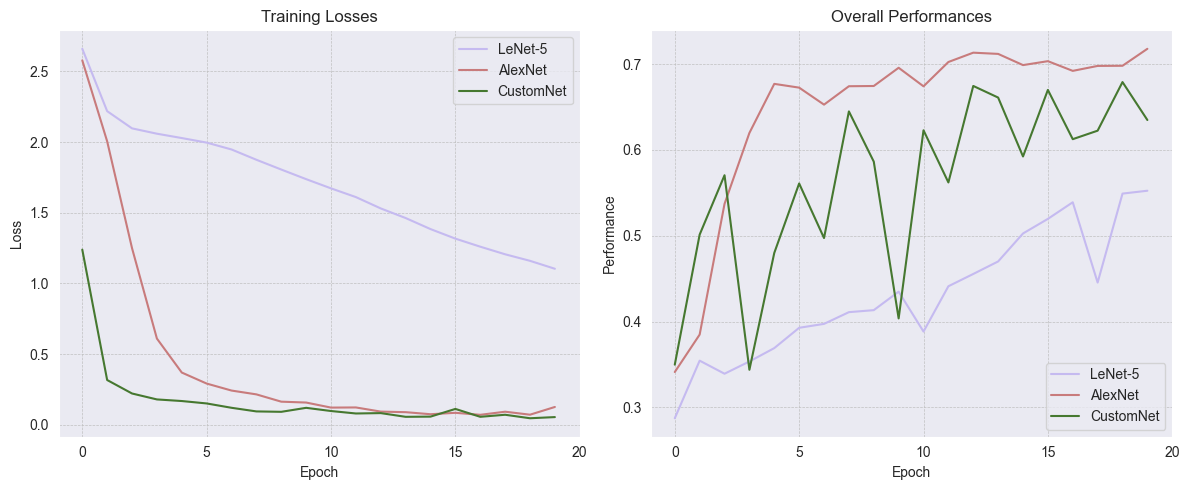

In [33]:
plot_model_performances(model_info_list, epochs=n_epochs)

In [34]:
def plot_model_predictions(model, dataset, model_name):
    model.eval()
    sample_indices = np.random.choice(len(dataset), 25, replace=False)
    fig, axs = plt.subplots(5, 5, figsize=(12, 11))
    axs = axs.ravel()

    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            sample = dataset[idx]
            img, y_true = sample
            img_tensor = img.unsqueeze(0).to(device)  # add batch dimension and move to device
            y_pred = model(img_tensor).squeeze(0)

            true_p_c = y_true[0].item()
            pred_p_c = torch.sigmoid(y_pred[0]).item() > 0.5  # predicted object presence

            true_class = int(y_true[5].item())
            pred_class = torch.argmax(y_pred[5:]).item()

            img_np = (img.numpy() * 255).astype(np.uint8)
            axs[i].imshow(img_np.squeeze(), cmap="Greys")

            # Draw true bounding box
            if true_p_c:
                x_min_t, y_min_t, x_max_t, y_max_t = get_bbox(*y_true[1:5])
                rect_true = Rectangle((x_min_t, y_min_t), x_max_t - x_min_t,
                                      y_max_t - y_min_t, linewidth=2, edgecolor="limegreen", facecolor="none",
                                      clip_on=True)
                axs[i].add_patch(rect_true)
                axs[i].text(x_min_t, y_min_t, f"y_true:{true_class}", fontsize=8,
                            bbox=dict(facecolor="limegreen", alpha=0.8, edgecolor="limegreen"), clip_on=True)

            # Draw predicted bounding box
            if pred_p_c:
                x_min_p, y_min_p, x_max_p, y_max_p = get_bbox(*y_pred[1:5].cpu().numpy())
                rect_pred = Rectangle((x_min_p, y_min_p), x_max_p - x_min_p,
                                      y_max_p - y_min_p, linewidth=2, edgecolor="crimson", facecolor="none",
                                      clip_on=True)
                axs[i].add_patch(rect_pred)
                axs[i].text(x_max_p, y_max_p, f"y_pred:{pred_class}", fontsize=8,
                            bbox=dict(facecolor="crimson", alpha=0.8, edgecolor="crimson"), clip_on=True)

            axs[i].set_title(f"true: {true_class} / pred: {pred_class}" if pred_p_c else "-")
            axs[i].axis('off')

    fig.suptitle(f"{model_name}\nTrue vs. Predicted Outcomes", fontsize=15)
    plt.tight_layout()
    plt.show()

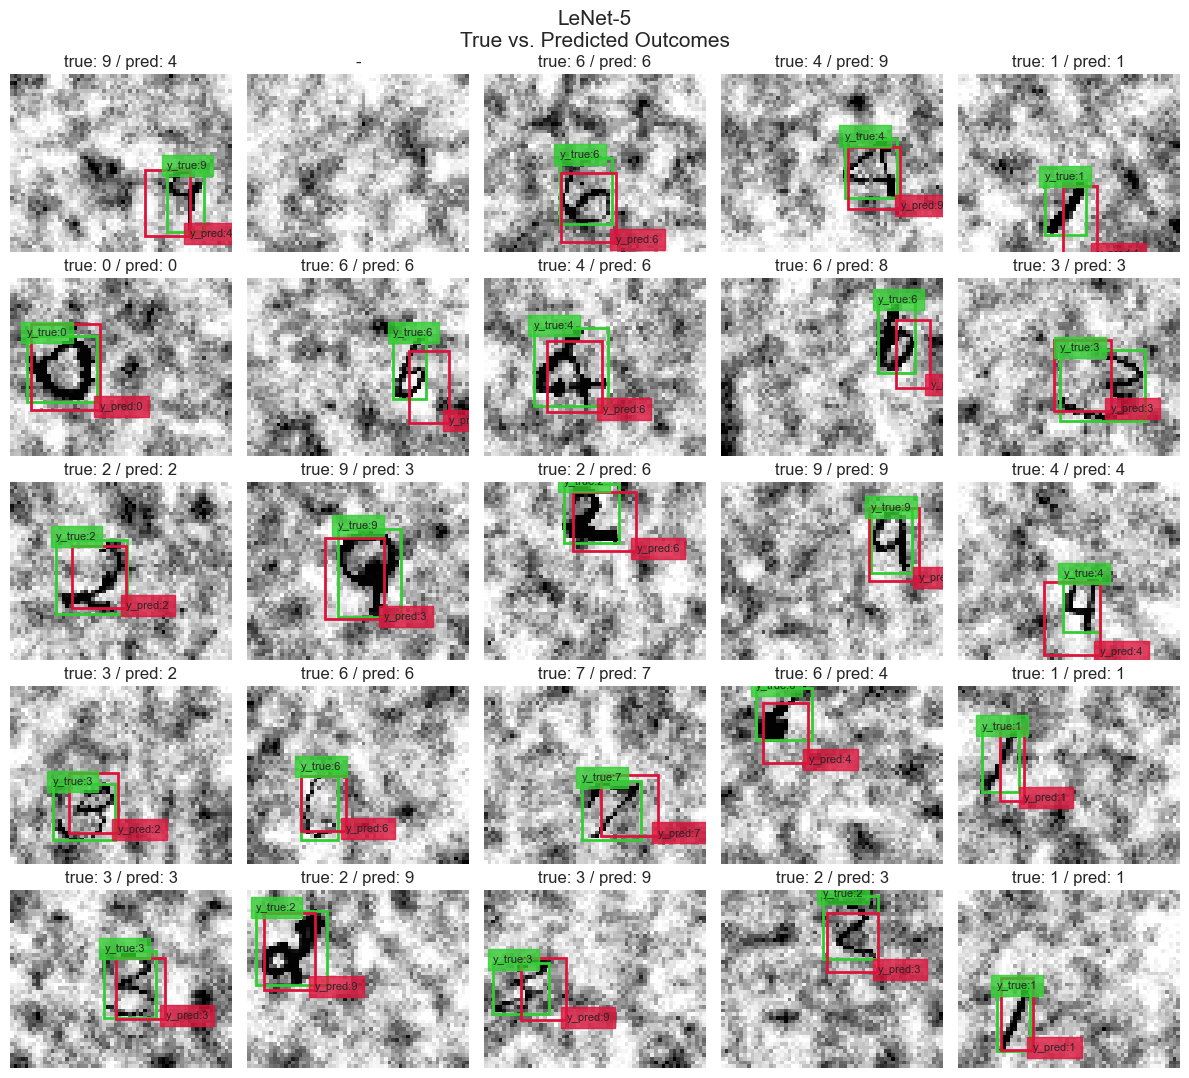

In [35]:
plot_model_predictions(LeNet5_model, train_dataset, model_name="LeNet-5")

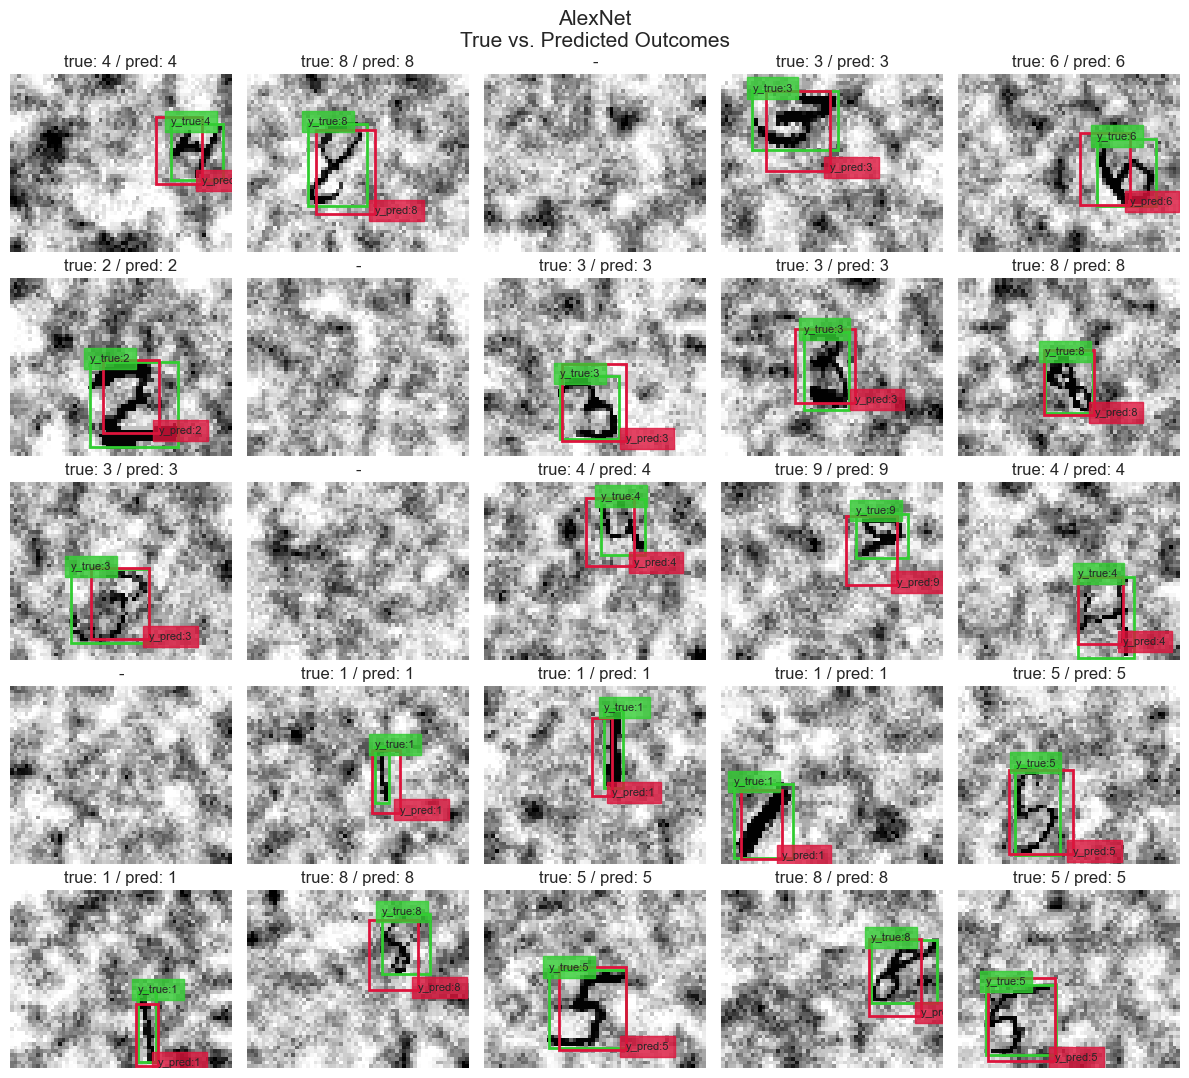

In [36]:
plot_model_predictions(AlexNet_model, train_dataset, model_name="AlexNet")

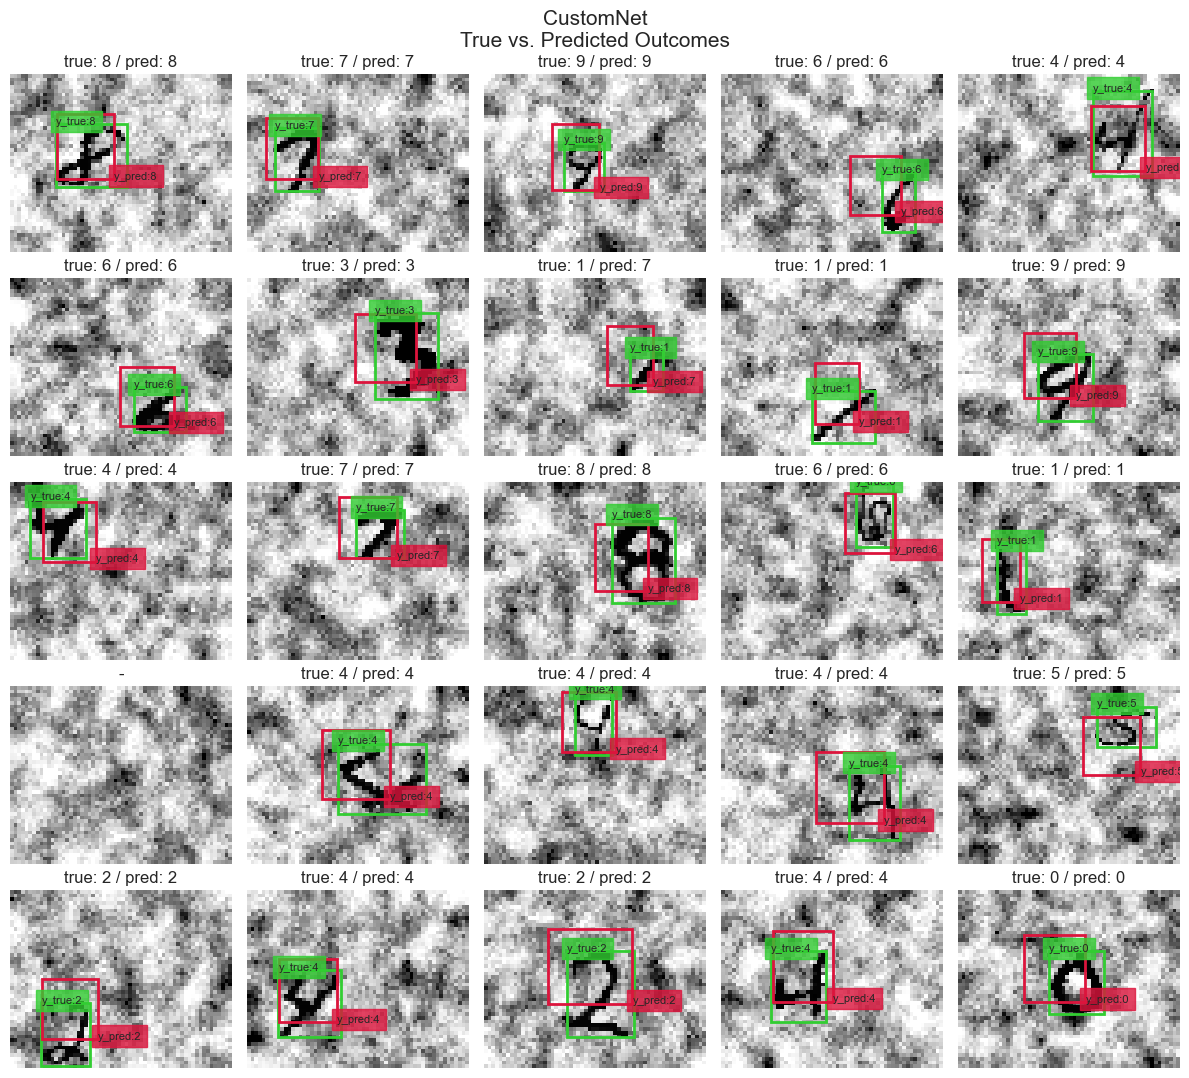

In [37]:
plot_model_predictions(CustomNet_model, train_dataset, model_name="CustomNet")

In [ ]:
def select_and_evaluate_best_model(model_info_list, test_loader):
    # Select the best model based on overall performance
    best_model_info = max(model_info_list, key=lambda x: x['performance'][-1])
    best_model = best_model_info['model']
    best_model_name = best_model_info['name']

    # Evaluate the selected model
    avg_classification_accuracy, avg_iou, avg_overall_performance = evaluate_model(best_model, test_loader)

    best_model_info = {
        'model': best_model,
        'model_name': best_model_name,
        'classification_accuracy': avg_classification_accuracy,
        'iou': avg_iou,
        'overall_performance': avg_overall_performance
    }

    return best_model_info

In [ ]:
best_model = select_and_evaluate_best_model(model_info_list, test_loader)

In [ ]:
print(f"Best Model: {best_model['model_name']}")
print(f"Classification Accuracy on Test Set: {best_model['classification_accuracy']:.5f}")
print(f"IoU on Test Set: {best_model['iou']:.5f}")
print(f"Overall Performance on Test Set: {best_model['overall_performance']:.5f}")

In [ ]:
def generate_predictions(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs[:, 5:], dim=1)

            # Filter out predictions where the object is not detected
            pred_pc = torch.sigmoid(outputs[:, 0]) > 0.5
            true_pc = labels[:, 0] == 1

            valid_indices = pred_pc & true_pc
            true_classes = labels[valid_indices][:, -1].long()
            predicted_classes = preds[valid_indices]

            y_true.append(true_classes.view(-1))
            y_pred.append(predicted_classes.view(-1))

    return torch.cat(y_true), torch.cat(y_pred)

In [ ]:
y_true, y_pred = generate_predictions(best_model['model'], test_loader)

In [ ]:
def plot_confusion_matrix(model_name, y_true, y_pred):
    if device.type == 'cuda':
        y_true = y_true.cpu()
        y_pred = y_pred.cpu()

    cm = confusion_matrix(y_true.numpy(), y_pred.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    fig, ax = plt.subplots(figsize=(7, 7))
    disp.plot(cmap='PuBuGn', ax=ax)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [ ]:
plot_confusion_matrix(best_model['model_name'], y_true, y_pred)

In [ ]:
if device.type == 'cuda':
    y_true_cpu = y_true.cpu().numpy()  # move to CPU and convert to numpy
    y_pred_cpu = y_pred.cpu().numpy()  # move to CPU and convert to numpy
    print(classification_report(y_true_cpu, y_pred_cpu))
else:
    print(classification_report(y_true, y_pred))

# 3. Object Detection

3.1.1 Data preparation of `y_true`

In [38]:
list_y_true_train = torch.load('data/list_y_true_train.pt')
list_y_true_val = torch.load('data/list_y_true_val.pt')
list_y_true_test = torch.load('data/list_y_true_test.pt')

In [39]:
detection_train = torch.load('data/detection_train.pt')
detection_val = torch.load('data/detection_val.pt')
detection_test = torch.load('data/detection_test.pt')

In [40]:
batch_size = 256
detection_train_loader = DataLoader(detection_train, batch_size=batch_size, shuffle=True)
detection_val_loader = DataLoader(detection_val, batch_size=batch_size, shuffle=True)
detection_test_loader = DataLoader(detection_test, batch_size=batch_size, shuffle=True)

In [41]:
def global_to_local(y_true, H_out=2, W_out=3):
    grid = torch.zeros((H_out, W_out, 6))
    cell_width = 1.0 / W_out
    cell_height = 1.0 / H_out

    for obj in y_true:
        obj = obj.clone()

        # calculate the cell index for x and y
        cell_x = int(obj[1] // cell_width)
        cell_y = int(obj[2] // cell_height)

        # normalize x and y to the cell: find the relative position within the cell
        obj[1] = (obj[1] % cell_width) / cell_width
        obj[2] = (obj[2] % cell_height) / cell_height

        # adjust width and height based on grid size
        obj[3] /= cell_width
        obj[4] /= cell_height

        # place the object tensor in the correct grid cell
        grid[cell_y, cell_x] = obj

    return grid

In [42]:
def local_to_global(grid, H_out=2, W_out=3):  # converting for performance calculation
    cell_width = 1.0 / W_out
    cell_height = 1.0 / H_out
    bboxes = []

    for cell_y in range(H_out):
        for cell_x in range(W_out):
            p_c, x, y, w, h, c = grid[cell_y, cell_x]

            # check if the cell contains an object
            if p_c == 1:
                # reverse normalization and adjustment for x, y, w, and h
                x = (x + cell_x) * cell_width
                y = (y + cell_y) * cell_height
                w = w * cell_width
                h = h * cell_height

                # reconstruct the original bounding box
                bbox = torch.tensor([p_c, x, y, w, h, c], dtype=torch.float32)
                bboxes.append(bbox)

    return bboxes

In [43]:
detection_y_true_train = [global_to_local(list_y_true) for list_y_true in list_y_true_train]

In [44]:
# original list of lists of tensors of shape 6
list_y_true_train[0]

[tensor([1.0000, 0.2583, 0.4062, 0.1167, 0.3958, 1.0000]),
 tensor([1.0000, 0.6500, 0.6667, 0.2333, 0.3333, 0.0000])]

In [45]:
# processed list_y_true_train for a 2×3 grid
detection_y_true_train[0]

tensor([[[1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [46]:
# compare with already processed (N, H, W, 6) tensor from detection_train dataset
# procedure was successful, the grids are identical ✔️
detection_train[0][1]

tensor([[[1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [47]:
local_to_global(detection_train[0][1])  # same as list_y_true_train[0] ✔️

[tensor([1.0000, 0.2583, 0.4062, 0.1167, 0.3958, 1.0000]),
 tensor([1.0000, 0.6500, 0.6667, 0.2333, 0.3333, 0.0000])]

In [48]:
# extract images from detection_train
detection_img_train = list(map(lambda x: x[0], detection_train))

In [49]:
def get_bbox_in_grid(x, y, w, h, grid_row, grid_col, img_height=48, img_width=60, grid_rows=2, grid_cols=3):
    # calculate the dimensions of each grid cell
    cell_height = img_height / grid_rows
    cell_width = img_width / grid_cols

    # calculate the top left corner of the grid cell
    cell_x_min = grid_col * cell_width
    cell_y_min = grid_row * cell_height

    # convert bounding box format from [center_x, center_y, width, height] to [x_min, y_min, x_max, y_max]
    x_min = cell_x_min + (x - w / 2) * cell_width
    y_min = cell_y_min + (y - h / 2) * cell_height
    x_max = cell_x_min + (x + w / 2) * cell_width
    y_max = cell_y_min + (y + h / 2) * cell_height

    return [x_min, y_min, x_max, y_max]

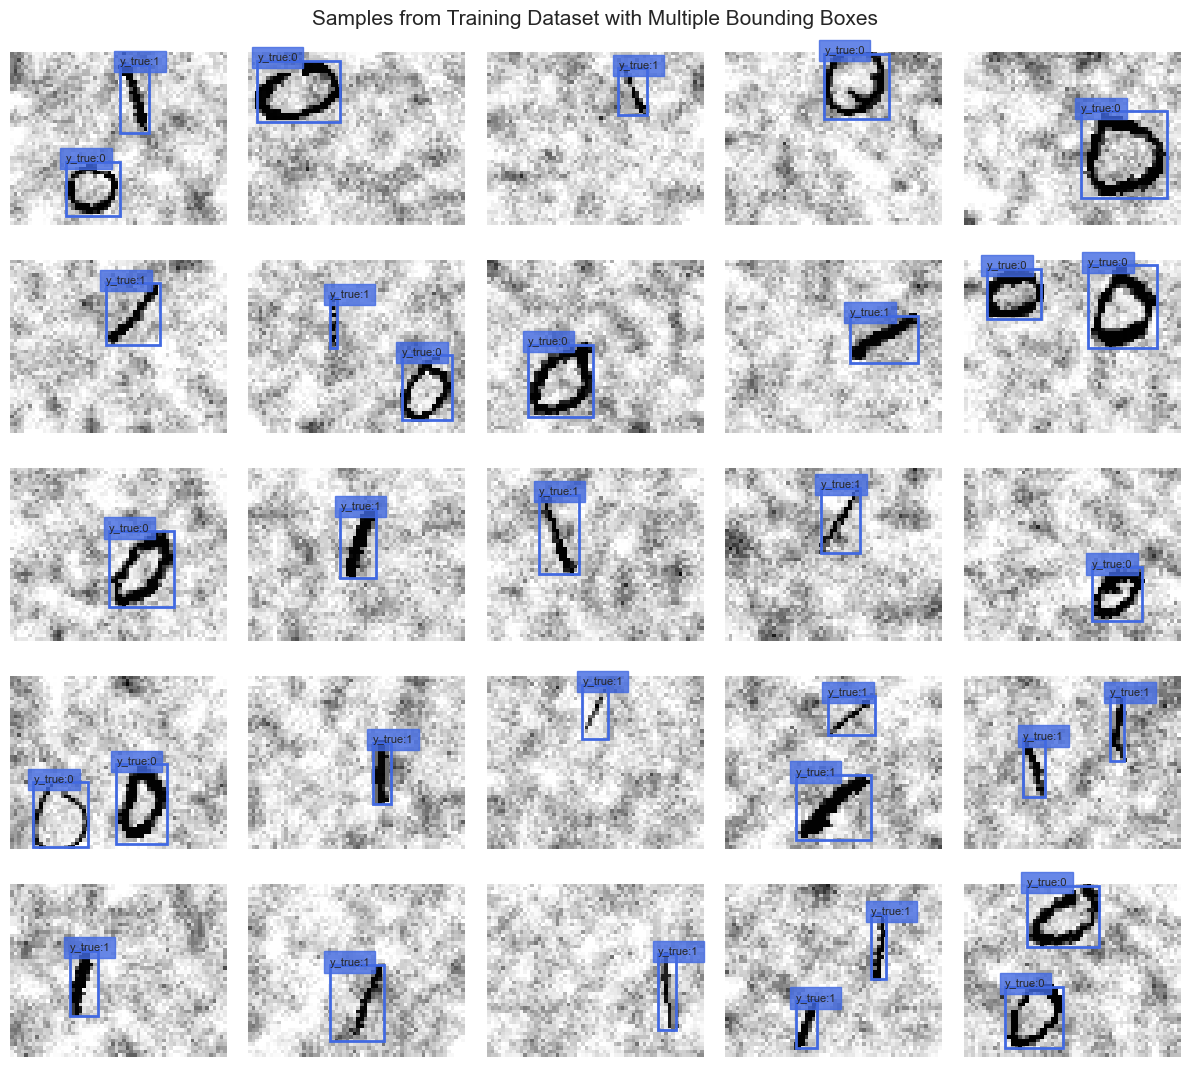

In [50]:
sample_indices = np.random.choice(len(detection_y_true_train), 25, replace=False)
fig, axs = plt.subplots(5, 5, figsize=(12, 11))

for ax, idx in zip(axs.ravel(), sample_indices):
    img = (detection_img_train[idx] * 255).to(torch.uint8).numpy().squeeze()
    for row, y_true_list in enumerate(detection_y_true_train[idx]):
        for col, (p_c, x, y, w, h, c) in enumerate(y_true_list):
            if p_c == 1:
                x_min, y_min, x_max, y_max = get_bbox_in_grid(x, y, w, h, row, col)
                # Rectangle expects the bottom left corner of the rectangle and its width and height
                rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor="royalblue",
                                 facecolor="none")
                ax.add_patch(rect)
                ax.text(x_min, y_min, f"y_true:{int(c)}", fontsize=8,
                        bbox=dict(facecolor="royalblue", alpha=0.8, edgecolor="royalblue"))

    ax.imshow(img, cmap="Greys")
    ax.axis("off")

fig.suptitle("Samples from Training Dataset with Multiple Bounding Boxes", fontsize=15)
plt.tight_layout()
plt.show()

In [51]:
class ObjectDet(nn.Module):
    def __init__(self):
        super(ObjectDet, self).__init__()
        # (n + 2p - f) / s + 1
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3, padding=1)
        # Conv1: Input 48x60x1 -> Output 48x60x2

        self.conv2 = nn.Conv2d(2, 4, kernel_size=3, padding=1)
        # Conv2: Input 24x30x1 -> Output 24x30x4

        self.conv3 = nn.Conv2d(4, 6, kernel_size=3, padding=1)
        # Conv3: Input 12x15x4 -> Output 12x15x6

        self.conv4 = nn.Conv2d(6, 7, kernel_size=3, padding=0)
        # Conv4: Input 4x5x6 -> Output 2x3x7 (H_out × W_out × (C + 5))

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.conv4(x)

        # outputs has a shape of [batch_size, 7, 2, 3] = [batch_size, channels, grid_height, grid_width]
        # we want to transform it to [batch_size, 2, 3, 7], (to match targets)
        return x.permute(0, 2, 3, 1)

In [52]:
def detection_loss_fn(y_pred, y_true, H_out=2, W_out=3):
    total_loss = 0

    # iterate over each cell in the grid for the entire batch
    for h in range(H_out):
        for w in range(W_out):
            # select the predictions and true values for the current cell across the entire batch
            pred = y_pred[:, h, w, :]  # [N, C+5]
            true = y_true[:, h, w, :]  # [N, 6]

            # calculate the object localization loss for the current cell across the entire batch
            loss = localization_loss_fn(pred, true)

            # accumulate the loss
            total_loss += loss

    return total_loss

In [53]:
def object_detection_train(model, optimizer, data_loader, epochs=10):
    model.train()

    for epoch in range(1, epochs + 1):
        total_loss = 0

        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(images)

            # calculate loss
            loss = detection_loss_fn(outputs, labels)

            # backward pass and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # calculate average loss for the epoch
        epoch_loss = total_loss / len(data_loader)
        timestamp = datetime.now().strftime('%H:%M:%S.%f')
        print(f"{timestamp} | Epoch {epoch} | Training Loss: {epoch_loss:.5f}")

In [54]:
ObjectDet_model = ObjectDet().to(device)
optimizer = torch.optim.Adam(ObjectDet_model.parameters(), lr=0.001)
object_detection_train(ObjectDet_model, optimizer, detection_train_loader)

19:53:26.532894 | Epoch 1 | Training Loss: 4.63947
19:53:33.677186 | Epoch 2 | Training Loss: 3.74378
19:53:41.110957 | Epoch 3 | Training Loss: 3.18897
19:53:47.998596 | Epoch 4 | Training Loss: 2.96044
19:53:55.676885 | Epoch 5 | Training Loss: 2.80173
19:54:02.667213 | Epoch 6 | Training Loss: 2.67871
19:54:09.627769 | Epoch 7 | Training Loss: 2.59146
19:54:17.588151 | Epoch 8 | Training Loss: 2.52063
19:54:24.888537 | Epoch 9 | Training Loss: 2.42991
19:54:32.024199 | Epoch 10 | Training Loss: 2.34042


In [60]:
def plot_det_model_predictions(model, dataset, model_name, H_out=2, W_out=3):
    model.eval()
    sample_indices = np.random.choice(len(dataset), 25, replace=False)
    fig, axs = plt.subplots(5, 5, figsize=(12, 11))
    axs = axs.ravel()

    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            img, y_true_grid = dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)  # add batch dimension and move to device
            y_pred_grid = model(img_tensor).squeeze(0)

            img_np = (img.numpy() * 255).astype(np.uint8)
            axs[i].imshow(img_np.squeeze(), cmap="Greys")

            for row in range(H_out):
                for col in range(W_out):
                    true_cell = y_true_grid[row, col]
                    pred_cell = y_pred_grid[row, col]

                    true_p_c = true_cell[0].item()
                    pred_p_c = torch.sigmoid(pred_cell[0]).item() > 0.5  # predicted object presence

                    # draw true bounding box if an object is present in the true data
                    if true_p_c:
                        x_min_t, y_min_t, x_max_t, y_max_t = get_bbox_in_grid(*true_cell[1:5], row, col)
                        true_class = int(true_cell[5].item())
                        rect_true = Rectangle((x_min_t, y_min_t), x_max_t - x_min_t, y_max_t - y_min_t, linewidth=1.5,
                                              edgecolor='limegreen', facecolor='none')
                        axs[i].add_patch(rect_true)
                        axs[i].text(x_min_t, y_min_t, f'y_true: {true_class}', fontsize=8,
                                    bbox=dict(facecolor='limegreen', alpha=0.8, edgecolor="limegreen"))

                    # draw predicted bounding box if an object is present in the prediction
                    if pred_p_c:
                        x_min_p, y_min_p, x_max_p, y_max_p = get_bbox_in_grid(*pred_cell[1:5].cpu().numpy(), row, col)
                        pred_class = torch.argmax(pred_cell[5:]).item()
                        rect_pred = Rectangle((x_min_p, y_min_p), x_max_p - x_min_p, y_max_p - y_min_p,
                                              linewidth=1.5, edgecolor='crimson', facecolor='none')
                        axs[i].add_patch(rect_pred)
                        axs[i].text(x_min_p, y_max_p, f'y_pred: {pred_class}', fontsize=8,
                                    bbox=dict(facecolor='crimson', alpha=0.8, edgecolor="red"))

            axs[i].axis('off')

    fig.suptitle(f"{model_name}\nTrue vs. Predicted Outcomes", fontsize=15)
    plt.tight_layout()
    plt.show()

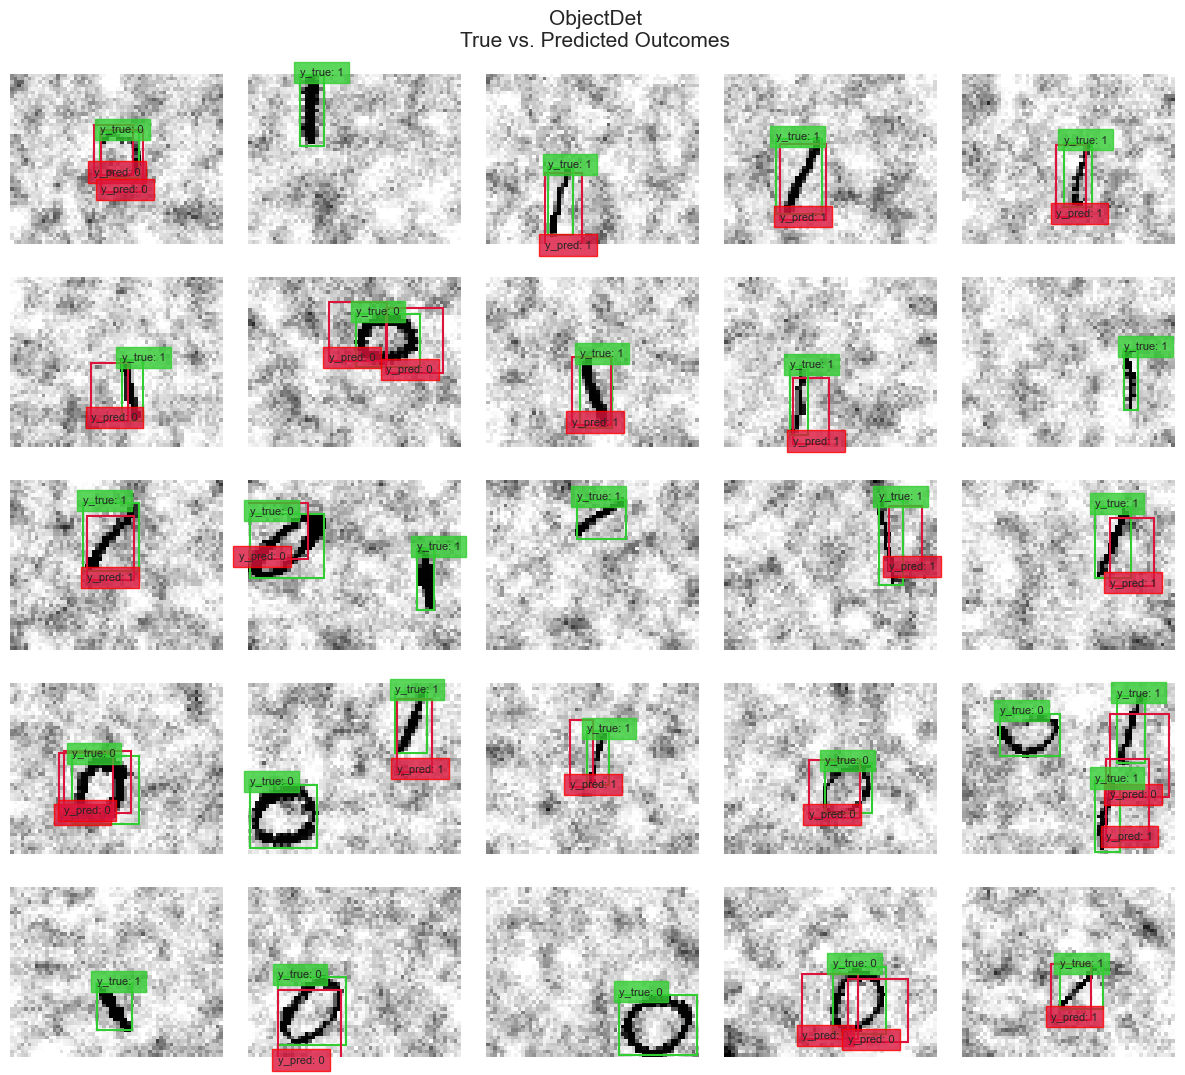

In [61]:
plot_det_model_predictions(ObjectDet_model, detection_train, "ObjectDet")